# DFIM: Recovering interactions between embedded motifs

In this example notebook we will recover interactions between embedded motifs. In real DNA sequences many features - such as DNA binding motifs - interact or depend on each other to regulate gene expression. Traditionally we can identify these motifs in a sequence, but their relationship to each other - such as whether they work together or not - is more difficult to untangle. DFIM is a method to identify such learned interactions between features from a deep learning model. We apply it here to simulated sequences where we have embedded known motifs into a random background so that we can see how the method works in a case study where we know ground truth. 

We have simulated three sets sequences:

- Class 1: 20,000 sequences with motif A (the SIX5 motif) embedded 1-2 times
- Class 2: 20,000 sequences with motif B (the ELF1 motif) embedded 1-2 times
- Class 3: 20,000 sequences with motif A and motif B (SIX5 and ELF1) each embedded 1-2 times


We have pre-trained a model learned to only predict a positive label when both motifs are present. Class 3 sequences with both motifs are positive and Class 1 and 2 with one or the other are both negative. The model must learn the interaction between motif A and B to make correct predictions. We also randomly add in motifs C and D (AP1 and TAL1) 0, 1, or 2 times into all 60,000 sequences to further simulate real sequences where there may be many repeated patterns that do not necessarily relate to the prediction task at hand.

Knowing the ground truth, we show that DFIM recovers an interaction between motifs A and B in Class 3 sequences but not between any other of the embedded motifs. 

In [1]:
# Imports

import os, sys
import numpy as np
import pandas as pd
import gzip

import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt

import pickle
import itertools

from keras.models import model_from_json
from Bio import SeqIO

import dfim
import dfim.util
import dfim.core
import dfim.null_model


Using Theano backend.
Using gpu device 5: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5105)


In [2]:
# Specify data files

labels_file = 'embedded_motif_interaction_data/labels.txt.gz'
fasta_file = 'embedded_motif_interaction_data/sequences.fa.gz'
simdata_file = 'embedded_motif_interaction_data/simulation_metadata.txt.gz'

model_weights = 'embedded_motif_interaction_data/model_weights.h5'
model_architecture = 'embedded_motif_interaction_data/model_architecture.json'


## Set up data and model
In the first part of this example we will:
- Load the simulated DNA sequences
- Load a trained model using Keras
- Get the sequences our model correctly predicted
- Identify the locations in these sequences where our motifs were embedded


In [3]:
# Load sequences

fasta_sequences = SeqIO.parse(gzip.open(fasta_file),'fasta')

sequence_list = []
seq_fasta_list = []

for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    seq_fasta_list.append(sequence)
    new_sequence = dfim.util.one_hot_encode(sequence)
    sequence_list.append(new_sequence)
    
sequences = np.array(sequence_list)


In [4]:
# Load model 

model_json = open(model_architecture, 'r').read()
model = model_from_json(model_json)
model.load_weights(model_weights)

In [5]:
# Get all correctly predicted positive sequences

all_labels = pd.read_table(labels_file)
all_predictions = model.predict(sequences)

true_labels = all_labels.iloc[:, 3].tolist()
predicted_labels = all_predictions[:, 0].tolist()

correct_pred_list = dfim.util.get_correct_predictions(true_labels, predicted_labels)


In [6]:
# Subset to 1,000 Class 3 sequences to speed the example

compute_range = range(50000, 51000)
compute_index = [el for el in compute_range if el in correct_pred_list]


In [7]:
# Recover known locations of motifs

mutant_loc_dict = dfim.util.process_locations_from_simdata(sequences, simdata_file)


## Computing DFIM 

Now we're going to compute DFIM on our sequences with the following procedure:
1. Compute mutated sequences at each motif location
2. Compute the change in prediction for each of these disruptions
3. Compute the importance scores for each original and mutated sequence
4. Compute "delta profiles" between mutated and original sequences
5. Combine these delta profiles into sequence-level interactions maps of all motifs in the sequence

In [8]:
# Generate mutated sequences and a key that specifies the index of each 
# of the sequence and which mutation is present there
(mutated_seq_array, mutated_seq_key) = \
            dfim.core.generate_mutants_and_key(sequences, 
                                               mut_loc_dict=mutant_loc_dict,
                                               sequence_index=compute_index)

# Look at how these mutations change the model's predictions
mutated_seq_preds = model.predict(mutated_seq_array)

# Compute importance scores for original and mutated sequences
score_dict = dfim.core.compute_importance(model, mutated_seq_array, 
                                          tasks=[2],
                                          score_type='gradient_input',
                                          find_scores_layer_idx=0,
                                          target_layer_idx=-2)

# Compute the change in importance scores as a result of each mutation
tasks = [2]
delta_dict = dfim.core.compute_delta_profiles(score_dict, mutated_seq_key, 
                                              mutant_loc_dict, tasks, 
                                              compute_index, 
                                              mutated_seq_preds)


# Compute DFIM by taking the maximal total affect across all 4 bases for each position
dfim_dict = dfim.core.compute_dfim(delta_dict, compute_index, tasks,
                                   operations=[np.sum, np.max], 
                                   operation_axes=[1, 0],
                                   absolute_value=True, annotate=True, 
                                   mutated_seq_key=mutated_seq_key)



Generating mutated sequences
Calculating Importance Scores
nonlinear_mxts_mode is set to: Gradient
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Done 0
Done 1000
Done 2000
Done 3000


## Computing DFIM of shuffled sequences for fitting a NULL model

We're now going to compute a null distribution of interaction scores by shuffling our input sequences and re-computing DFIM maps. 


In [9]:
# Shuffle sequences
shuf_sequences = dfim.null_model.shuffle_seq_from_one_hot(sequences, dinuc=False)


# Repeat DFIM procedure
(shuf_mutated_seq_array, shuf_mutated_seq_key) = \
            dfim.core.generate_mutants_and_key(shuf_sequences, 
                                               mut_loc_dict=mutant_loc_dict,
                                               sequence_index=compute_index)
    
shuf_mutated_seq_preds = model.predict(shuf_mutated_seq_array)

shuf_score_dict = dfim.core.compute_importance(model, shuf_mutated_seq_array, 
                                               tasks=[2],
                                               score_type='gradient_input',
                                               find_scores_layer_idx=0,
                                               target_layer_idx=-2)

shuf_delta_dict = dfim.core.compute_delta_profiles(shuf_score_dict, shuf_mutated_seq_key, 
                                                   mutant_loc_dict, tasks, compute_index, 
                                                   shuf_mutated_seq_preds)


shuf_dfim_dict = dfim.core.compute_dfim(shuf_delta_dict, compute_index, tasks,
                                        operations=[np.sum, np.max], 
                                        operation_axes=[1, 0],
                                        absolute_value=True, annotate=True, 
                                        mutated_seq_key=shuf_mutated_seq_key)



Using random shuffle
Generating mutated sequences
Calculating Importance Scores
nonlinear_mxts_mode is set to: Gradient
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
Done 0
Done 1000
Done 2000
Done 3000


The DFIM package enables p-values to be computed in two ways. The default is to "fit" a NULL distribution as opposed to using empirical p-values. With a sufficient number of sequences we can fit a Gaussian distribution to the distribution of DFIM scores for the NULL model and assign a p-value to each true score according to this distribution. This is the (null_type = 'fit') p-value. With insufficient data points, we can otherwise assign an empirical p-value according to how many interaction scores in the NULL distribution the true interaction scores are greater than (null_type = 'empirical').

We also set the distribution NULL p-values on several levels: by individual sequence or map (null_level='per_map'), by each task (null_level='per_task'), or for all values in the analysis (null_level='global'). This determines what values the Gaussian will be fit with. The default is 'per_task' but if sequences are highly variable (such as widely ranging GC content, etc.) it can be better to fit 'per_map' or if you don't have enough sequences and want to use all data for your NULL then 'global' can be a good option.


In [10]:
### Compute Pvalues 

all_motifs = ['TAL1', 'ELF1', 'SIX5', 'AP1']

dfim_pval_dict = dfim.null_model.assign_pval(dfim_dict, 
                                             shuf_dfim_dict,
                                             null_level = 'per_task',
                                             null_type = 'fit')


interact_score_dict = {'_'.join(sorted([m1, m2])): [] 
                           for (m1, m2) 
                           in itertools.combinations(all_motifs, 2)} 

for task in dfim_pval_dict.keys():
    for seq in dfim_pval_dict[task].keys():
        for i in dfim_pval_dict[task][seq].index:
            
            row_motif = i.split('_')[1]
            
            for c in dfim_pval_dict[task][seq].columns:
                col_motif = c.split('_')[1]
                
                if i == c:
                    continue
                else:
                    interact_score_dict['_'.join(sorted([row_motif, col_motif]))].append(
                                                 dfim_pval_dict[task][seq].loc[i, c])


## Visualize learned interactions

Now we can visualize our results. We can look at how the p-values of the interaction scores for our embedded motifs that interact are highly significant, while all other interactions between embedded motifs are not. Cool! You can see how this might be applied in real DNA sequences  where there are many motifs present, but only a subset of them interact. DFIM can help identify those interactions.

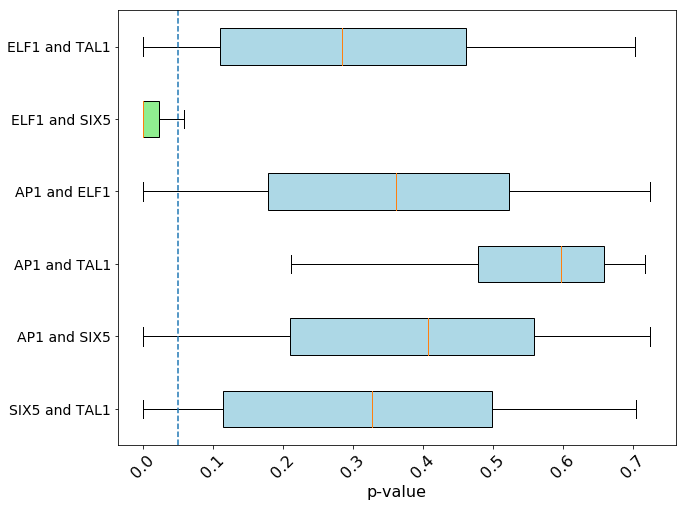

In [11]:
%matplotlib inline  

all_data = [interact_score_dict[perm] 
                for perm in interact_score_dict.keys()]
labels = interact_score_dict.keys()
tick_labels = [' and '.join([l.split('_')[0], 
                             l.split('_')[1]]) 
                       for l in labels]

plt.figure(figsize=(10,8))
bplot1 = plt.boxplot(all_data, patch_artist=True,
                     labels=tick_labels, 
                     showfliers=False,
                     widths=0.5,
                     vert=False)
plt.tick_params(labelsize=14)
plt.axvline(0.05, ls='dashed')
plt.xticks(rotation=45, fontsize=16)
plt.xlabel('p-value', fontsize=16)
colors = ['lightblue']*len(tick_labels)
colors[-2] = 'lightgreen'
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
plt.show()